In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

import seaborn as sns
from ete3 import Tree, NodeStyle, TextFace, TreeStyle, CircleFace, faces, AttrFace
from Bio import Entrez
import re
Entrez.email = "lukas.becker@hhu.de"

from goatools.obo_parser import GODag
go_dag = GODag("../data/goatools_data/go-basic.obo")

import os
os.environ['QT_QPA_PLATFORM']='offscreen'

../data/goatools_data/go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms


In [2]:
go_table = pd.read_table("../data/transcriptomics_data/pannzer/curvibacter_aep/GO.out")
go_table = go_table[go_table["ARGOT_PPV"] >= 0.6]
translation_table = pd.read_table("../data/transcriptomics_data/translation_table_corrected.csv")
deseq_table = pd.read_csv("../data/transcriptomics_data/hydra_vs_liquid_mouth_opening_paper.csv", sep=";")
deseq_table.log2FoldChange = deseq_table.log2FoldChange.apply(lambda x: float(x.replace(",",".")))
deseq_table.padj = deseq_table.padj.apply(lambda x: float(x.replace(",",".")))
enriched_upregulated_table = pd.read_csv("../results/processed_data/goatools_output/mouth_opening/goatools_results_06_up.txt", sep="\t")

In [3]:
deseq_table_meta = pd.read_csv("../data/transcriptomics_data/metatranscriptome_vs_liquid_mono_culture_orgint.csv")
deseq_table_meta["old_locus_tag"] = deseq_table_meta["Unnamed: 0"].apply(lambda x: x.split(":")[-1])

In [4]:
deseq_table_virus = pd.read_csv("../data/transcriptomics_data/hydra_vs_liquid.csv")
deseq_table_virus = deseq_table_virus.rename(columns={"Unnamed: 0":"locus_tag"})

In [5]:
amino_acid_enriched = enriched_upregulated_table[enriched_upregulated_table["name"] == "amino acid transport"]
enriched_amino_acid_transporter = []
for amino_acid_transporter in amino_acid_enriched.study_items.values[0].split(","):
    amino_acid_transporter = amino_acid_transporter.strip()
    enriched_amino_acid_transporter.append(amino_acid_transporter)

In [6]:
amino_acid_transport = go_table[go_table.goid == 6865]
amino_acid_transport = amino_acid_transport.rename(columns={"qpid":"protein_id"})
amino_acid_transport = amino_acid_transport.merge(translation_table, on="protein_id")
amino_acid_transport.head()

,protein_id,ontology,goid,desc,ARGOT_score,ARGOT_PPV,ARGOT_rank,goclasscount,old_locus_tag,locus_tag
0,WP_087493730.1,BP,6865,amino acid transport,6.288023,0.668803,2,59,AEP_00267,AEP_RS01365
1,WP_087493732.1,BP,6865,amino acid transport,6.525583,0.675617,1,99,AEP_00269,AEP_RS01375
2,WP_087494276.1,BP,6865,amino acid transport,6.525255,0.675607,3,48,AEP_00888,AEP_RS04470
3,WP_087494354.1,BP,6865,amino acid transport,6.525628,0.675618,1,92,AEP_00980,AEP_RS04935
4,WP_087494355.1,BP,6865,amino acid transport,6.525616,0.675618,1,99,AEP_00981,AEP_RS04940


<Axes: >

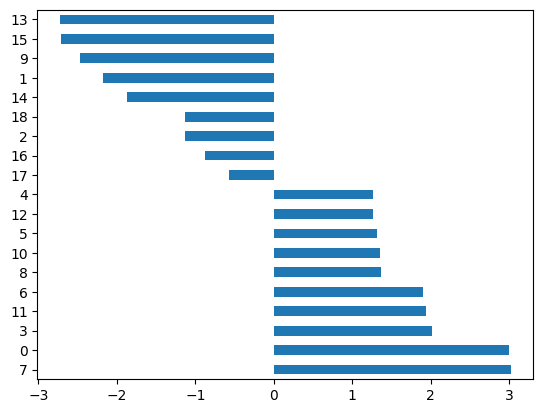

In [7]:
diff_exp_amino_acids_virus = deseq_table_virus.merge(amino_acid_transport, on="locus_tag")
diff_exp_amino_acids_virus = diff_exp_amino_acids_virus[diff_exp_amino_acids_virus.padj <= 0.05]
diff_exp_amino_acids_virus = diff_exp_amino_acids_virus.sort_values(by="log2FoldChange", ascending=False)
diff_exp_amino_acids_virus.log2FoldChange.plot(kind="barh")

<Axes: >

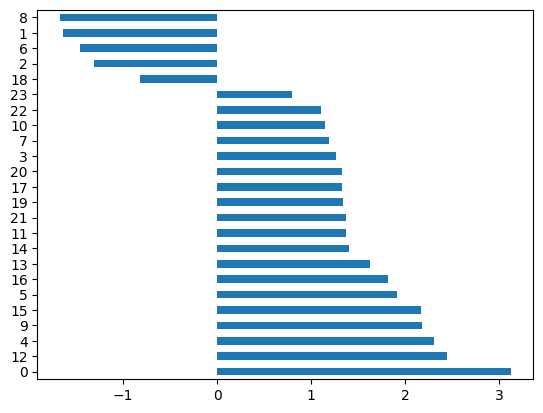

In [8]:
diff_exp_amino_acids_meta = deseq_table_meta.merge(amino_acid_transport, on="old_locus_tag")
diff_exp_amino_acids_meta = diff_exp_amino_acids_meta[diff_exp_amino_acids_meta.padj <= 0.05]
diff_exp_amino_acids_meta = diff_exp_amino_acids_meta.sort_values(by="log2FoldChange", ascending=False)
diff_exp_amino_acids_meta.log2FoldChange.plot(kind="barh")

<Axes: >

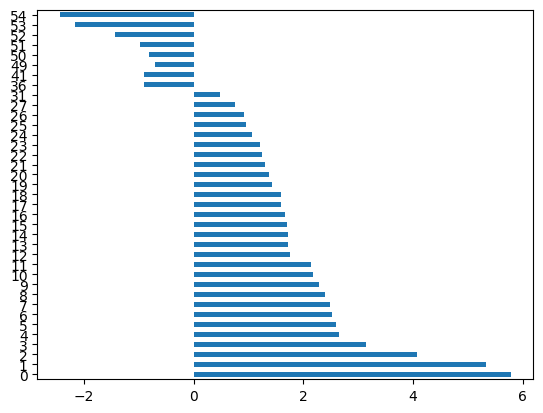

In [9]:
diff_exp_amino_acids = deseq_table.merge(amino_acid_transport, on="locus_tag")
diff_exp_amino_acids = diff_exp_amino_acids[diff_exp_amino_acids.padj <= 0.05]
diff_exp_amino_acids.log2FoldChange.plot(kind="barh")

In [10]:
len(diff_exp_amino_acids[diff_exp_amino_acids.log2FoldChange >= 1.0])

25

In [11]:
len(diff_exp_amino_acids[diff_exp_amino_acids.log2FoldChange <= -1.0])

3

In [12]:
55 - 28

27

In [23]:
len(diff_exp_amino_acids)

37

In [13]:
tpm_table = pd.read_csv("../results/processed_data/tpm_table_mouth_opening.csv", index_col=0)
aa_tpm_table = tpm_table[tpm_table.locus_tag.isin(diff_exp_amino_acids.locus_tag)]
aa_tpm_table.index = aa_tpm_table["locus_tag"]
aa_tpm_table = aa_tpm_table.iloc[:,1:]

<Figure size 1000x800 with 0 Axes>

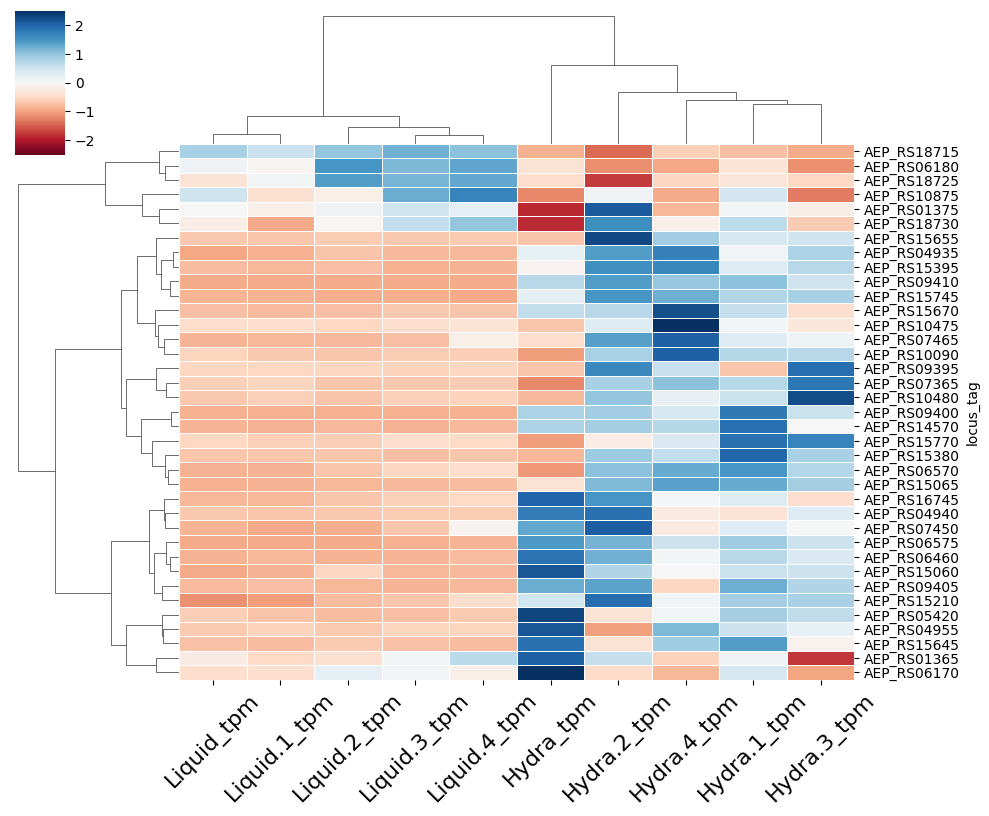

In [14]:
# Set figure size
plt.figure(figsize=(10, 8))

# Create clustermap
g = sns.clustermap(
    aa_tpm_table, 
    cmap="RdBu",        # Color map (can be changed, e.g., "coolwarm", "magma", "RdBu_r")
    method="ward",         # Clustering method (alternatives: "average", "single", "complete")
    metric="euclidean",    # Distance metric (alternatives: "correlation", "cosine")
    figsize=(10, 8),       # Figure size
    z_score=0,             # Standardize rows (0 for genes, 1 for samples, None for no scaling)
    linewidths=0.5,        # Add space between heatmap cells
    xticklabels=True,      # Show sample names
    yticklabels=True,
    vmax=2.5, vmin=-2.5,# Show gene names
)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize=16, rotation=45)  # Rotate if needed

# Adjust yticklabel fontsize
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=10)

#plt.title("Gene Expression Heatmap with Clustering")
plt.savefig("../results/figures/transcriptomics/aa_transporter_heatmap_tpm_vals.svg")

# Getting descriptions for amino acid transporters based on pannzer annotation

In [15]:
annot_table = pd.read_table("../data/transcriptomics_data/pannzer/curvibacter_aep/anno.out", sep="\t")
#annot_table.head()

In [16]:
tab = annot_table[annot_table.qpid.isin(amino_acid_transport.protein_id)][["qpid","desc"]]
tab.head()

,qpid,desc
6884,WP_087493730.1,ATP-binding cassette domain-containing protein...
6885,WP_087493730.1,MTDTKPLKLQVENIHKRFGSNEVLKGVSLSAHAGDVISIIGSSGSG...
6886,WP_087493730.1,"ABC-type histidine transport system, ATPase co..."
6887,WP_087493730.1,HISP
6888,WP_087493730.1,Histidine transport ATP-binding protein HisP


In [17]:
amino_acid_transporter_dict = {
    "WP_087493730.1" : "Histidine - HisP",
    "WP_087493732.1" : "Histidine - HisM",
    "WP_087494276.1": "Leucine, Threonine, Homoserine (Neutral) - LysE",
    "WP_087494354.1": "Leucine-, isoleucine-, valine-, threonine-, and alanine-binding protein",
    "WP_087494355.1" : "Branched chain - LivH",
    "WP_087494358.1" : "Branched chain - LivF",
    "WP_087494574.1" : "Leucine-, isoleucine-, valine-, threonine-, and alanine-binding protein",
    "WP_087494576.1" : "Leucine-, isoleucine-, valine-, threonine-, and alanine-binding protein",
    "WP_087494627.1" : "Leucine, branched chain",
    "WP_087494647.1" : "General L-amino acid - AapQ",
    "WP_087494649.1" : "Glutamate/glutamine/aspartate/asparagine - BztD/GlnQ",
    "WP_087494785.1" : "Leucine, Threonine, Homoserine (Neutral) - LysE",
    "WP_087494800.1" : "Branched chain - LivF/UrtE",
    "WP_087494803.1" : "Amino acid/amide - UrtB",
    "WP_087494804.1" : "Branched chain - UrtA",
    "WP_087495141.1" : "Branched chain",
    "WP_087495142.1" : "Branched chain - LivF",
    "WP_087495143.1" : "Valine, Phenylalanine, Isoleucine, branched chain/aromatic amino acid",
    "WP_087495144.1" : "Leucine-, isoleucine-, valine-, threonine-, and alanine-binding protein",
    "WP_087495253.1" : "Leucine, Threonine, Homoserine (Neutral) - LysE", # Cysteine? 
    "WP_087494648.1" : "General L-amino acid - AapM",
    "WP_087495259.1" : "Leucine, Threonine (Neutral) - LysE",
    "WP_087495296.1" : "Leucine, Threonine (Neutral) - LysE",
    "WP_087495325.1" : "Glutamine - GlnP/GlnM",
    "WP_087495326.1" : "L-cystine - YecS/TcyB",
    "WP_087495400.1" : "Leucine-, isoleucine-, valine-, threonine-, and alanine-binding protein",
    "WP_087495666.1" : "Leucine - LivK_2",
    "WP_087494355.1" : "Branched chain - LivH",
    "WP_087495682.1" : "Leucine, Threonine (Neutral) - LysE",
    "WP_087495963.1" : "Branched chain - AzlC",
    "WP_087496052.1" : "Arginine / Histidine - ArtM",
    "WP_087496136.1" : "Branched chain",
    "WP_087496137.1" : "Branched chain - LivH",
    "WP_087496140.1" : "Branched chain - LivF",
    "WP_087496160.1" : "Branched chain - LivF",
    "WP_087496163.1" : "Branched chain - LivH",
    "WP_087496164.1" : "Branched chain",
    "WP_087496194.1" : "Branched chain",
    "WP_087496197.1" : "Branched chain - LivF",
    "WP_087496244.1" : "Leucine-, isoleucine-, valine-, threonine-, and alanine-binding protein",
    "WP_087496246.1" : "Branched chain - LivF",
    "WP_087496249.1" : "Branched chain - LivH",
    "WP_087496266.1" : "Leucine, Threonine (Neutral) - LysE",
    "WP_087496440.1" : "Branched chain - LivH",
    "WP_087496441.1" : "Branched chain - LivF",
    "WP_087496442.1" : "Branched chain - LivG",
    "WP_087496443.1" : "Branched chain",
    "WP_087496455.1" : "General L-amino acid",
    "WP_087496795.1" : "Branched chain - LivH",
    "WP_087496797.1" : "Branched chain - LivG",
    "WP_087496798.1" : "Branched chain - LivF",
    "WP_087497046.1" : "Leucine - LeuE",
    "WP_198301822.1" : "General L-amino acid",
    "WP_198301841.1" : "General L-amino acid",
    "WP_232459936.1" : "Arginine / Lysine exporter - ArgO/LysE",
    "WP_232459948.1" : "Glutamate/glutamine/aspartate/asparagine - BztA"
}

In [21]:
len(amino_acid_transporter_dict)

55

In [18]:
aa_tpm_table_wp = aa_tpm_table.merge(translation_table, on="locus_tag")
aa_tpm_table_wp["desc"] = [amino_acid_transporter_dict[prot_id] for prot_id in aa_tpm_table_wp.protein_id]
aa_tpm_table_wp.index = aa_tpm_table_wp["desc"]
aa_tpm_table_wp = aa_tpm_table_wp.loc[:,~aa_tpm_table_wp.columns.isin(["locus_tag","protein_id","old_locus_tag","desc"])]

In [20]:
len(aa_tpm_table_wp)

37

## Plot clustermap with updated amino acid descriptions

<Figure size 1000x800 with 0 Axes>

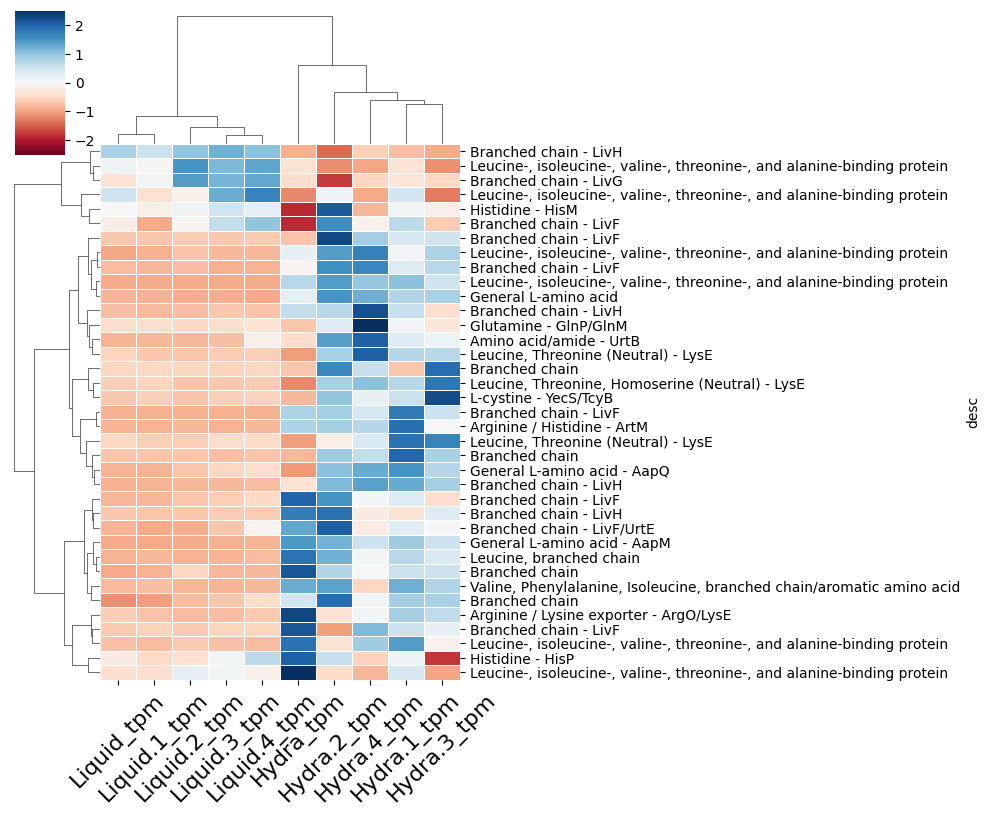

In [19]:
# Set figure size
plt.figure(figsize=(10, 8))

# Create clustermap
g = sns.clustermap(
    aa_tpm_table_wp, 
    cmap="RdBu",        # Color map (can be changed, e.g., "coolwarm", "magma", "RdBu_r")
    method="ward",         # Clustering method (alternatives: "average", "single", "complete")
    metric="euclidean",    # Distance metric (alternatives: "correlation", "cosine")
    figsize=(10, 8),       # Figure size
    z_score=0,             # Standardize rows (0 for genes, 1 for samples, None for no scaling)
    linewidths=0.5,        # Add space between heatmap cells
    xticklabels=True,      # Show sample names
    yticklabels=True,
    vmax=2.5, vmin=-2.5,# Show gene names
)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize=16, rotation=45)  # Rotate if needed

# Adjust yticklabel fontsize
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=10)

#plt.title("Gene Expression Heatmap with Clustering")
plt.savefig("../results/figures/transcriptomics/aa_transporter_heatmap_tpm_vals_with_desc.svg")

# Phylogeny with Amino Acid Transporter genes

In [17]:
# outgroup carbohydrate transport: 0008643
carbohydrate_transport = go_table[go_table["goid"] == 8643]

In [18]:
len(list(carbohydrate_transport.qpid.unique()))

18

In [19]:
handle = Entrez.efetch(db="protein", id=list(carbohydrate_transport.qpid.unique()),rettype="fasta", retmode="xml")
record = Entrez.read(handle)
handle.close()

In [20]:
carbo_fasta_file_path = "../results/processed_data/phylogenetics/entrez/carbohydrate_transporter_sequences.faa"
with open(carbo_fasta_file_path,"w") as fasta:
    for rec in record:
        identifier = rec["TSeq_accver"]
        header = ">" + identifier + "\n"
        sequence = rec['TSeq_sequence'] + "\n"
        fasta.write(header)
        fasta.write(sequence)

In [21]:
handle = Entrez.efetch(db="protein", id=list(amino_acid_transporter_dict.keys()),rettype="fasta", retmode="xml")
record = Entrez.read(handle)
handle.close()

In [22]:
amino_fasta_file_path = "../results/processed_data/phylogenetics/entrez/amino_transporter_sequences.faa"
with open(amino_fasta_file_path,"w") as fasta:
    for rec in record:
        identifier = rec["TSeq_accver"]
        header = ">" + identifier + "\t" + amino_acid_transporter_dict[identifier] + "\n"
        sequence = rec['TSeq_sequence'] + "\n"
        fasta.write(header)
        fasta.write(sequence)

In [26]:
#mafft_input = "../results/processed_data/phylogenetics/entrez/amino_transporter_sequences.faa"
mafft_input = "../results/processed_data/phylogenetics/entrez/mafft_input.faa"
!cat $carbo_fasta_file_path $amino_fasta_file_path > $mafft_input

In [27]:
#mafft_output = "../results/processed_data/phylogenetics/mafft/amino_acid_transporters.mafft"
mafft_output = "../results/processed_data/phylogenetics/mafft/amino_carbo_transporters.mafft"

In [29]:
!mafft --maxiterate 1000 --localpair $mafft_input > $mafft_output

outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
rescale = 1
All-to-all alignment.
tbfast-pair (aa) Version 7.453
alg=L, model=BLOSUM62, 2.00, -0.10, +0.10, noshift, amax=0.0
0 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   70 / 73
done.

Progressive alignment ... 
STEP    61 /72 
Reallocating..done. *alloclen = 2416
STEP    72 /72 
done.
tbfast (aa) Version 7.453
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
1 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 0
randomseed = 0
blosum 62 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
rescale = 1

   70 / 73
Segment   1/  1    1-1395
done 016-001-1  rejected..   epted. rejected. rejected. rejected. rejected. accepted. accepted. accepted. rejected. rejected. accepted. accepted. rejected.

In [20]:
#iqtree_path = "../results/processed_data/phylogenetics/iqtree/amino_transporter_"
iqtree_path = "../results/processed_data/phylogenetics/iqtree/amino_carbo_transporter_"
!iqtree -T 4 -s $mafft_output -m LG+R5 -bb 1000 -alrt 1000 -nt AUTO -pre $iqtree_path # --redo-tree

Use -pre <output_prefix>


In [20]:
iqtree_output = "../results/processed_data/phylogenetics/iqtree/amino_transporter_.treefile"
#iqtree_output = "../results/processed_data/phylogenetics/iqtree/amino_carbo_transporter_.treefile"

In [21]:
# Function to modify the tree format to be compatible with ETE3
def modify_treefile(input_treefile, output_treefile):
    with open(input_treefile, 'r') as infile:
        tree_content = infile.read()

    # Step 1: Handle bootstrap values like '99/100:0.8238979236'
    # We want to remove the '/100' part and keep just the first bootstrap value (e.g., '99')
    tree_content = re.sub(r'(\d+)/\d+:(\d+\.\d+)', r'\1:\2', tree_content)

    # Step 2: Handle the case of 'XX/YY:ZZ.ZZZ' (for both bootstrap and branch length)
    # Ensure the first bootstrap value is kept and the branch length format is correct
    tree_content = re.sub(r'(\d+\.\d+)/(\d+):(\d+\.\d+)', r'\1:\3', tree_content)

    with open(output_treefile, 'w') as outfile:
        outfile.write(tree_content)

    print(f"Tree file modified and saved as: {output_treefile}")


input_treefile = iqtree_output # Path to your original IQ-TREE output tree file
output_treefile = "../results/processed_data/phylogenetics/iqtree/ete3_newick.nwk" # Path to save the modified tree file

#output_treefile = "../results/processed_data/phylogenetics/iqtree/ete3_newick_amino_carbo.nwk" # Path to save the modified tree file

modify_treefile(input_treefile, output_treefile)

Tree file modified and saved as: ../results/processed_data/phylogenetics/iqtree/ete3_newick.nwk


In [22]:
float_values_dict = {}
for protein in amino_acid_transporter_dict.keys():
    diff_set = diff_exp_amino_acids[diff_exp_amino_acids.protein_id == protein]
    if len(diff_set) == 1:
        float_values_dict[protein] = diff_set.log2FoldChange.values[0]
    else:
        float_values_dict[protein] = 0.0

In [23]:
#norm = plt.Normalize(vmin=diff_exp_amino_acids.log2FoldChange.min(), vmax=diff_exp_amino_acids.log2FoldChange.max())
norm = plt.Normalize(vmin=-4.0, vmax=4.0)
cmap = plt.get_cmap("RdBu")  

# color dict for branch support
norm_branch = plt.Normalize(vmin=0, vmax=100)
cmap_branch = plt.get_cmap("RdYlGn")  

In [24]:
%%capture
tree = Tree(output_treefile, quoted_node_names=True)

def add_colored_circle(node):
    """Add a circle face to each leaf based on the float value"""
    if node.is_leaf():
        
        if node.name in list(float_values_dict.keys()):
            value = float_values_dict[node.name]            
            rgba = cmap(norm(value))  # Map the value to a color
            color = tuple(int(c * 255) for c in rgba[:3])
            def rgb_to_hex(r, g, b):
              return ('{:02X}' * 3).format(r, g, b)
            
            color = rgb_to_hex(color[0], color[1], color[2])
            color = "#" + color
            circle_face = CircleFace(radius=10, color=color, style="circle")  # Circle size and outline style
            node.add_face(circle_face, column=1)  # Place circle next to the name

for node in tree.traverse():
    add_colored_circle(node)

for leaf in tree:
    if leaf.name in amino_acid_transporter_dict:
        leaf.name = amino_acid_transporter_dict[leaf.name]


    
def set_node_color(node):
    if node.is_leaf():
        return "black"
    else:
        bootstrap_value = node.support
        rgba = cmap_branch(norm_branch(bootstrap_value))  # Map the value to a color
        color = tuple(int(c * 255) for c in rgba[:3])
        def rgb_to_hex(r, g, b):
          return ('{:02X}' * 3).format(r, g, b)
        
        color = rgb_to_hex(color[0], color[1], color[2])
        color = "#" + color
        return color

for node in tree.traverse():
    node_style = NodeStyle()
    #node_style["fgcolor"] = set_node_color(node)  # Set color for the node/branch
    node_style["vt_line_color"] = set_node_color(node)
    node_style["hz_line_color"] = set_node_color(node)
    node_style["vt_line_width"] = 8
    node_style["hz_line_width"] = 8
    node_style["vt_line_type"] = 0 # 0 solid, 1 dashed, 2 dotted
    node_style["hz_line_type"] = 0
    #node_style["size"] = 20
    #node_style["shape"] = "square"
    node.set_style(node_style)
    
ete3_output = "../results/figures/ete3_tree_amino_acid_transporter.svg"

# Step 4: Customize TreeStyle
tree_style = TreeStyle()
tree_style.layout_fn = lambda node: node.add_face(TextFace(node.name), column=0)

# IMPORTANT: Correct mode option here for unrooted tree
tree_style.mode = "c"  # Unrooted circular layout, NOT 'phylo' or other types
tree_style.show_leaf_name = False  # Ensure leaf names are shown
# Step 5: Adjust branch lengths (scaling factor)
# We can increase the branch lengths by multiplying the distance values.
#scaling_factor = 8  # You can modify this value for longer or shorter branches
#for node in tree.traverse():
#    if node.is_root():
#        continue  # Skip root node
#    node.dist = node.dist * scaling_factor  # Scale the branch length

tree_style.scale = 120
tree_style.arc_start = -180
tree_style.arc_span = 180

tree.render(ete3_output, tree_style=tree_style)


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'


# Pie chart analysis of child go terms

In [25]:
print("[0]")
child_list = []
for child in go_dag["GO:0006865"].children:
    print(child.id, child.name)
    child_list.append(child.id)
    for next_child in go_dag[child.id].children:
        if next_child.id not in child_list:
            child_list.append(next_child.id)
            print("\t",next_child.id,next_child.name)

print("[1]")
for child in go_dag["GO:0015803"].children:
    print(child.id, child.name)
    child_list.append(child.id)
    for next_child in go_dag[child.id].children:
        if next_child.id not in child_list:
            child_list.append(next_child.id)
            print("\t",next_child.id,next_child.name)

print("[2]")
for child in go_dag["GO:0015658"].children:
    print(child.id, child.name)
    child_list.append(child.id)
    for next_child in go_dag[child.id].children:
        if next_child.id not in child_list:
            child_list.append(next_child.id)
            print("\t",next_child.id,next_child.name)

child_list.append("GO:0006865")
child_list.append("GO:0015803")
child_list.append("GO:0015658")

[0]
GO:0042940 D-amino acid transport
	 GO:0042942 D-serine transmembrane transport
	 GO:0070777 D-aspartate transmembrane transport
	 GO:0042941 D-alanine transmembrane transport
	 GO:0048473 D-methionine transmembrane transport
GO:0015800 acidic amino acid transport
	 GO:0051938 L-glutamate import
	 GO:0014047 glutamate secretion
	 GO:0090454 glutamate transmembrane import into vacuole
	 GO:0051939 gamma-aminobutyric acid import
	 GO:0061528 aspartate secretion
GO:0015812 gamma-aminobutyric acid transport
	 GO:0051936 gamma-aminobutyric acid reuptake
	 GO:0014051 gamma-aminobutyric acid secretion
GO:0003333 amino acid transmembrane transport
	 GO:1903713 asparagine transmembrane transport
	 GO:0090455 ornithine transmembrane import into vacuole
	 GO:0032973 amino acid export across plasma membrane
	 GO:1903714 isoleucine transmembrane transport
	 GO:0032974 amino acid transmembrane export from vacuole
	 GO:0034487 vacuolar amino acid transmembrane transport
	 GO:0032975 amino acid tr

In [26]:
def format_number(number):
    return f"GO:{int(number):07d}"

In [27]:
go_table["go_id"] = go_table.goid.apply(lambda x: format_number(x) )
go_table.head()

,qpid,ontology,goid,desc,ARGOT_score,ARGOT_PPV,ARGOT_rank,goclasscount,go_id
0,WP_006296472.1,CC,1990904,ribonucleoprotein complex,4.512266,0.613135,1,99,GO:1990904
20,WP_006299042.1,CC,1990904,ribonucleoprotein complex,4.507298,0.612965,1,1,GO:1990904
40,WP_007861702.1,MF,70180,large ribosomal subunit rRNA binding,9.757452,0.758260,1,99,GO:0070180
41,WP_007861702.1,CC,22625,cytosolic large ribosomal subunit,7.058988,0.690478,1,99,GO:0022625
43,WP_007861702.1,CC,15934,large ribosomal subunit,6.598746,0.677690,2,99,GO:0015934


In [28]:
goids_to_transporter_dict = {}
amino_transporter_go_table = go_table[go_table.qpid.isin(list(amino_acid_transporter_dict.keys()))]
for transporter in amino_acid_transporter_dict.keys():
    goids_to_transporter_dict[transporter] = ["GO:0006865"]
    for goid in amino_transporter_go_table[amino_transporter_go_table.qpid == transporter].go_id:
        if goid in child_list:
            goids_to_transporter_dict[transporter].append(goid)

In [29]:
from collections import defaultdict

In [30]:
# Group keys by their value sets
grouped = defaultdict(list)

for key, value_set in goids_to_transporter_dict.items():
    grouped[frozenset(value_set)].append(key)  # Use frozenset to make it hashable

# Convert defaultdict to a regular dict
result = dict(grouped)

# Print grouped result
for values, keys in result.items():
    print("######################")
    for val in values:
        print(val, go_dag[val].name)
    print(f"{keys}")
    print(len(keys))
    #print(f"Values {set(values)}: Keys {keys}")

######################
GO:0006865 amino acid transport
GO:0003333 amino acid transmembrane transport
['WP_087493730.1', 'WP_087494649.1', 'WP_087494785.1', 'WP_087495259.1', 'WP_087495296.1', 'WP_232459936.1']
6
######################
GO:0006865 amino acid transport
['WP_087493732.1', 'WP_087494354.1', 'WP_087494355.1', 'WP_087494574.1', 'WP_087494576.1', 'WP_087494627.1', 'WP_087494647.1', 'WP_087494803.1', 'WP_087494804.1', 'WP_087495141.1', 'WP_087495144.1', 'WP_087494648.1', 'WP_087495325.1', 'WP_087495326.1', 'WP_087495400.1', 'WP_087495666.1', 'WP_087496052.1', 'WP_087496136.1', 'WP_087496137.1', 'WP_087496163.1', 'WP_087496164.1', 'WP_087496194.1', 'WP_087496244.1', 'WP_087496249.1', 'WP_087496440.1', 'WP_087496443.1', 'WP_198301822.1', 'WP_198301841.1', 'WP_232459948.1']
29
######################
GO:0006865 amino acid transport
GO:0015804 neutral amino acid transport
GO:0042968 homoserine transport
['WP_087494276.1', 'WP_087496266.1']
2
######################
GO:0006865 amino a

In [31]:
diff_exp_amino_acids["padj"] = diff_exp_amino_acids["padj"].round(3)
for s in result.keys():
    print("####################################################################")
    print(s)
    print(result[s])
    print(diff_exp_amino_acids[diff_exp_amino_acids.protein_id.isin(result[s])][["protein_id","log2FoldChange","padj"]])

####################################################################
frozenset({'GO:0006865', 'GO:0003333'})
['WP_087493730.1', 'WP_087494649.1', 'WP_087494785.1', 'WP_087495259.1', 'WP_087495296.1', 'WP_232459936.1']
        protein_id  log2FoldChange   padj
17  WP_087495259.1        1.598900  0.000
22  WP_087494785.1        1.254639  0.002
26  WP_232459936.1        0.914242  0.003
41  WP_087493730.1       -0.902659  0.006
####################################################################
frozenset({'GO:0006865'})
['WP_087493732.1', 'WP_087494354.1', 'WP_087494355.1', 'WP_087494574.1', 'WP_087494576.1', 'WP_087494627.1', 'WP_087494647.1', 'WP_087494803.1', 'WP_087494804.1', 'WP_087495141.1', 'WP_087495144.1', 'WP_087494648.1', 'WP_087495325.1', 'WP_087495326.1', 'WP_087495400.1', 'WP_087495666.1', 'WP_087496052.1', 'WP_087496136.1', 'WP_087496137.1', 'WP_087496163.1', 'WP_087496164.1', 'WP_087496194.1', 'WP_087496244.1', 'WP_087496249.1', 'WP_087496440.1', 'WP_087496443.1', 'WP_1983

In [32]:
# per hand annotation:
go_to_wp_dict = {"GO:0003333\namino acid transmembrane transport" : ['WP_087493730.1', 'WP_087494649.1', 'WP_087494785.1', 'WP_087495259.1', 'WP_087495296.1', 'WP_232459936.1'],
"GO:0006865\namino acid transport" : ['WP_087493732.1', 'WP_087494354.1', 'WP_087494355.1', 'WP_087494574.1', 'WP_087494576.1', 'WP_087494627.1', 'WP_087494647.1', 'WP_087494803.1', 'WP_087494804.1', 'WP_087495141.1', 'WP_087495144.1', 'WP_087494648.1', 'WP_087495325.1', 'WP_087495326.1', 'WP_087495400.1', 'WP_087495666.1', 'WP_087496052.1', 'WP_087496136.1', 'WP_087496137.1', 'WP_087496163.1', 'WP_087496164.1', 'WP_087496194.1', 'WP_087496244.1', 'WP_087496249.1', 'WP_087496440.1', 'WP_087496443.1', 'WP_198301822.1', 'WP_198301841.1', 'WP_232459948.1'],
 "GO:0015804;GO:0042968\nneutral amino acid/homoserine transport" : ['WP_087494276.1', 'WP_087496266.1'],
 "GO:0015803;GO:0015658\nbranched chain amino acid transmembrane/transport" : ['WP_087494358.1', 'WP_087494800.1', 'WP_087495142.1', 'WP_087496140.1', 'WP_087496160.1', 'WP_087496197.1', 'WP_087496246.1', 'WP_087496441.1', 'WP_087496798.1'],
 "GO:0015803;GO:0015658;GO:0089718\nbranched chain amino acid transmembrane/transport/import" : ['WP_087495143.1', 'WP_087496442.1', 'WP_087496797.1'],
 "GO:0042883\ncysteine transport" :  ['WP_087495253.1'],
 "GO:0015803;GO:0015658;GO:0015820\nL-leucine transport": ['WP_087495682.1', 'WP_087497046.1'],
 "GO:0015803;GO:0015829\nvaline transport" :  ['WP_087495963.1'],
 "GO:0003333;GO:0015810\ntransmembrane aspartate transport" : ['WP_087496455.1'],
 "GO:0015803;GO:0015658;GO:0015808\nL-alanine transport" : ['WP_087496795.1']
}

In [33]:
colors = [
    "#1f77b4",  # Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#8c564b",  # Brown
    "#e377c2",  # Pink
    "#7f7f7f",  # Gray
    "#bcbd22",  # Olive
    "#17becf"   # Cyan
]
color_dict = {}
for col,key in enumerate(go_to_wp_dict.keys()):
    color_dict[key] = colors[col]

In [34]:
%%capture
tree = Tree(output_treefile, quoted_node_names=True)

def set_node_color(node):
    if node.is_leaf():
        return "black"
    else:
        bootstrap_value = node.support
        rgba = cmap_branch(norm_branch(bootstrap_value))  # Map the value to a color
        color = tuple(int(c * 255) for c in rgba[:3])
        def rgb_to_hex(r, g, b):
          return ('{:02X}' * 3).format(r, g, b)
        
        color = rgb_to_hex(color[0], color[1], color[2])
        color = "#" + color
        return color
        
def layout(node): 
    if node.is_leaf():
        node_name = node.name
        for desc in go_to_wp_dict.keys():
            if node.name in go_to_wp_dict[desc]:
                node.name = desc#"                          "
                color_name = desc

        if node_name in list(float_values_dict.keys()):
            value = float_values_dict[node_name]
            fgcolor = "black"
            #if value > 3.0:
            #    fgcolor = "white"
            rgba = cmap(norm(value))
            color = tuple(int(c * 255) for c in rgba[:3])
            def rgb_to_hex(r, g, b):
              return ('{:02X}' * 3).format(r, g, b)
            
            color = rgb_to_hex(color[0], color[1], color[2])
            color = "#" + color
        
        t_face = TextFace(node.name,fgcolor="black", fsize=14)
        t_face.inner_background.color = color_dict[color_name] 
        
        node.add_face(t_face, column = 0, position="aligned")
        
        ns = NodeStyle()
        style = NodeStyle()
        
        style["shape"] = "circle"  # Shape of the node
        #style["size"] = size * 2    # Make the circle big enough
        style["fgcolor"] = "black"  # Border color around the circle
        #style["hz_align"] = "center"
        
        ns["hz_line_type"] = 2 
        ns["hz_line_color"] = "black"  
        ns["hz_line_width"] = 2
        node.set_style(ns)

        circle_face = CircleFace(radius=20, color=color, style="circle")  
        #circle_face.border.width = 2
        #circle_face.border.color = "black"
        node.add_face(circle_face, column=1, position="aligned") 
            
for leaf in tree:
    layout(leaf)

for node in tree.traverse():
    node_style = NodeStyle()
    if node.is_leaf() == False:
        node.add_face(TextFace(str(node.support), fsize=25, fstyle="bold"), column=0, position="branch-top")
        if node.support == 51.6:
            node.swap_children()
        if node.support == 51.7:
            node.swap_children()
        if node.support == 86.3:
            node.swap_children()
        if node.support == 66.2:
            node.swap_children()
        if node.support == 91.4:
            node.swap_children()
        if node.support == 92.0:
            node.swap_children()
        if node.support == 93.6:
            node.swap_children()
        if node.support == 63.2:
            node.swap_children()
    node_style["fgcolor"] = set_node_color(node)
    node_style["vt_line_color"] = set_node_color(node)
    node_style["hz_line_color"] = set_node_color(node)
    node_style["vt_line_width"] = 4
    node_style["hz_line_width"] = 4
    node_style["vt_line_type"] = 0
    node_style["hz_line_type"] = 0
    node_style["size"] = 6
    node_style["shape"] = "square"

    node.set_style(node_style)


tree_style = TreeStyle()
tree_style.mode = "r"  
tree_style.show_leaf_name = False
#tree_style.branch_vertical_margin = 15
tree_style.scale = 2

ete3_output = "../results/figures/ete3_tree_final.svg"
tree.render(ete3_output, tree_style=tree_style)

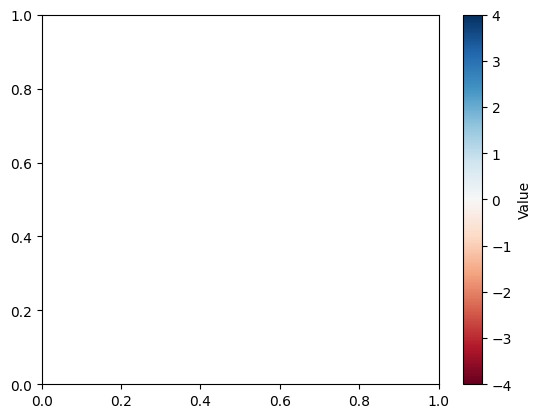

In [35]:
# Define the colormap and normalization
norm = mpl.colors.Normalize(vmin=-4.0, vmax=4.0)
cmap = plt.get_cmap("RdBu")


# Create the figure and add the colorbar
fig, ax = plt.subplots()
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for colorbar to work
cbar = plt.colorbar(sm, ax=ax)
# Label the colorbar (optional)
cbar.set_label("Value")
plt.savefig("../results/figures/colorbar_tree.svg")

In [36]:
# per hand annotation:
pie_chart_data = []
pie_chart_text = []
for key in go_to_wp_dict.keys():
    pie_chart_text.append(key)
    pie_chart_data.append(len(go_to_wp_dict[key]))

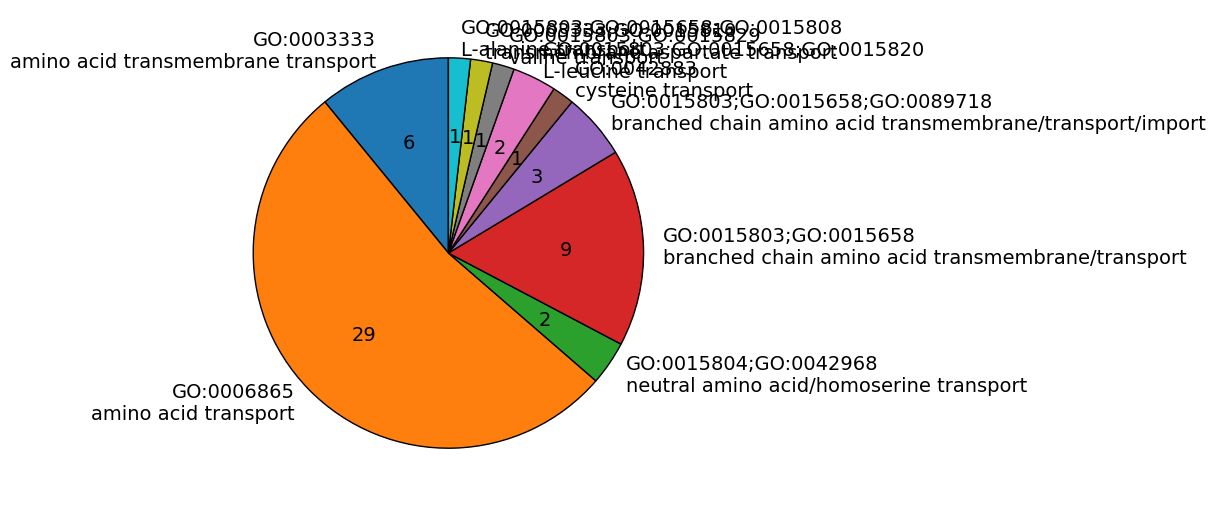

In [37]:
#colors = cm.get_cmap("tab20c", len(pie_chart_data)).colors
plt.figure(figsize=(10, 8))
plt.pie(
    pie_chart_data,
    labels=pie_chart_text,
    autopct=lambda p: '{:.0f}'.format(p * sum(pie_chart_data) / 100), #count_formatter(pct, counts) + f" - {pct:.2f}"
    #autopct=lambda pct: f"{pct:.1f}%" if pct > 2 else "",  # Show % only for >5%
    colors=colors,
    startangle=90,
    radius=1.0,
    wedgeprops={"edgecolor": "k"},
    textprops={"fontsize":14}# Add a border to slices
)
#plt.title("Amino Acid Transporter")
plt.tight_layout()
plt.savefig("../results/figures/amino_acid_transporter_pie_chart.svg")

In [38]:
sorted_lists = sorted(zip(pie_chart_data, pie_chart_text, colors), reverse=True)

# Unzipping back to separate lists
pie_chart_data, pie_chart_text, colors = map(list, zip(*sorted_lists))

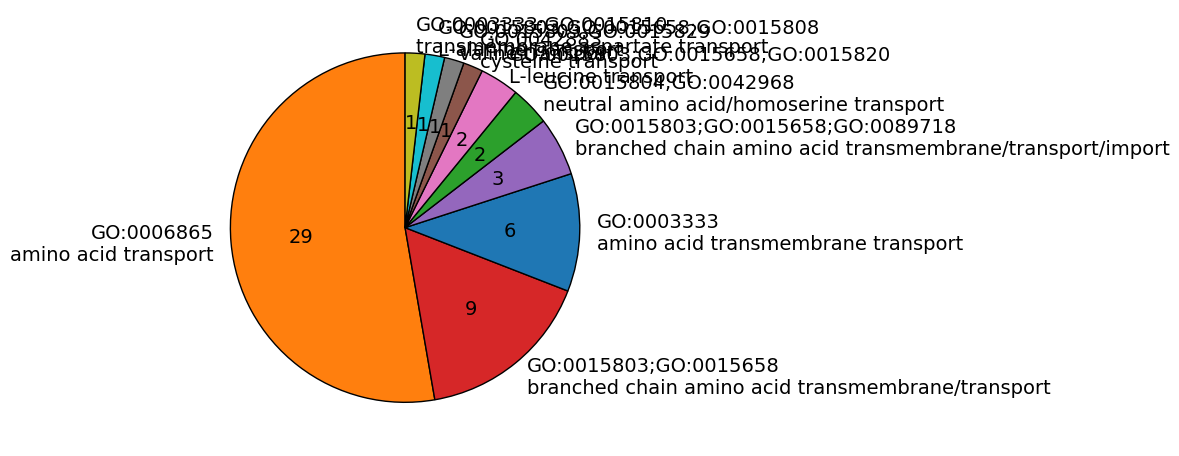

In [39]:
#colors = cm.get_cmap("tab20c", len(pie_chart_data)).colors
plt.figure(figsize=(10, 8))
plt.pie(
    pie_chart_data,
    labels=pie_chart_text,
    autopct=lambda p: '{:.0f}'.format(p * sum(pie_chart_data) / 100), #count_formatter(pct, counts) + f" - {pct:.2f}"
    #autopct=lambda pct: f"{pct:.1f}%" if pct > 2 else "",  # Show % only for >5%
    colors=colors,
    startangle=90,
    radius=1.0,
    wedgeprops={"edgecolor": "k"},
    textprops={"fontsize":14}# Add a border to slices
)
#plt.title("Amino Acid Transporter")
plt.tight_layout()
plt.savefig("../results/figures/amino_acid_transporter_pie_chart.svg")

In [40]:
amino_acid_transporter_dict

{'WP_087493730.1': 'Histidine - HisP',
 'WP_087493732.1': 'Histidine - HisM',
 'WP_087494276.1': 'Leucine, Threonine, Homoserine (Neutral) - LysE',
 'WP_087494354.1': 'Leucine-, isoleucine-, valine-, threonine-, and alanine-binding protein (branched chain)',
 'WP_087494355.1': 'Branched chain - LivH',
 'WP_087494358.1': 'Branched chain - LivF',
 'WP_087494574.1': 'Leucine-, isoleucine-, valine-, threonine-, and alanine-binding protein (branched chain)',
 'WP_087494576.1': 'Leucine-, isoleucine-, valine-, threonine-, and alanine-binding protein (branched chain)',
 'WP_087494627.1': 'Leucine, branched chain',
 'WP_087494647.1': 'General L-amino acid - AapQ',
 'WP_087494649.1': 'Glutamate/glutamine/aspartate/asparagine - BztD/GlnQ',
 'WP_087494785.1': 'Leucine, Threonine, Homoserine (Neutral) - LysE',
 'WP_087494800.1': 'Branched chain - LivF/UrtE',
 'WP_087494803.1': 'Amino acid/amide - UrtB',
 'WP_087494804.1': 'Branched chain - UrtA',
 'WP_087495141.1': 'Branched chain',
 'WP_087495142

In [41]:
go_to_wp_dict

{'GO:0003333\namino acid transmembrane transport': ['WP_087493730.1',
  'WP_087494649.1',
  'WP_087494785.1',
  'WP_087495259.1',
  'WP_087495296.1',
  'WP_232459936.1'],
 'GO:0006865\namino acid transport': ['WP_087493732.1',
  'WP_087494354.1',
  'WP_087494355.1',
  'WP_087494574.1',
  'WP_087494576.1',
  'WP_087494627.1',
  'WP_087494647.1',
  'WP_087494803.1',
  'WP_087494804.1',
  'WP_087495141.1',
  'WP_087495144.1',
  'WP_087494648.1',
  'WP_087495325.1',
  'WP_087495326.1',
  'WP_087495400.1',
  'WP_087495666.1',
  'WP_087496052.1',
  'WP_087496136.1',
  'WP_087496137.1',
  'WP_087496163.1',
  'WP_087496164.1',
  'WP_087496194.1',
  'WP_087496244.1',
  'WP_087496249.1',
  'WP_087496440.1',
  'WP_087496443.1',
  'WP_198301822.1',
  'WP_198301841.1',
  'WP_232459948.1'],
 'GO:0015804;GO:0042968\nneutral amino acid/homoserine transport': ['WP_087494276.1',
  'WP_087496266.1'],
 'GO:0015803;GO:0015658\nbranched chain amino acid transmembrane/transport': ['WP_087494358.1',
  'WP_087

In [42]:
color_dict

{'GO:0003333\namino acid transmembrane transport': '#1f77b4',
 'GO:0006865\namino acid transport': '#ff7f0e',
 'GO:0015804;GO:0042968\nneutral amino acid/homoserine transport': '#2ca02c',
 'GO:0015803;GO:0015658\nbranched chain amino acid transmembrane/transport': '#d62728',
 'GO:0015803;GO:0015658;GO:0089718\nbranched chain amino acid transmembrane/transport/import': '#9467bd',
 'GO:0042883\ncysteine transport': '#8c564b',
 'GO:0015803;GO:0015658;GO:0015820\nL-leucine transport': '#e377c2',
 'GO:0015803;GO:0015829\nvaline transport': '#7f7f7f',
 'GO:0003333;GO:0015810\ntransmembrane aspartate transport': '#bcbd22',
 'GO:0015803;GO:0015658;GO:0015808\nL-alanine transport': '#17becf'}

In [ ]:
#the following fields are required for each node:
#ID,TYPE,WHAT,COLOR,WIDTH_OR_SIZE_FACTOR,STYLE,BACKGROUND_COLOR

# TYPE: can be either 'branch' or 'label'. 'branch' will apply customizations to the tree branches, while 'labels' apply to the leaf text labels
# WHAT: can be either 'node' or 'clade', only relevant for internal tree nodes. 'Node' will apply the customization only to a single node, while 'clade' will apply to all child nodes as well.
# COLOR: can be in hexadecimal, RGB or RGBA notation. If RGB or RGBA are used, dataset SEPARATOR cannot be comma.
# WIDTH_OR_SIZE_FACTOR: for type 'branch', specifies the relative branch width, compared to the global branch width setting.
#                       for type 'label', specifies the relative font size, compared to the global font size
# STYLE: for type 'branch', can be either 'normal' or 'dashed'
#        for type 'label', can be one of 'normal', 'bold', 'italic' or 'bold-italic'
# BACKGROUND_COLOR (optional): only relevant for type 'label', specifies the color of the label background. The value is optional.

In [118]:
def scale(values,min_target, max_target, positive=True):
    
    vals = []
    for val in values.values():
        vals.append(abs(val))
    
    min_val = min(vals)
    max_val = max(vals)
    
    new_dict = {}
    for val in values.keys():
        if positive == True:
            new_dict[val] = (values[val] - min_val) / (max_val - min_val) * (min_target - max_target) + max_target
        else:
            new_dict[val] = (abs(values[val]) - min_val) / (max_val - min_val) * (min_target - max_target) + max_target
    return new_dict

In [109]:
negative_dict = {}
positive_dict = {}
for key in float_values_dict.keys():
    if float_values_dict[key] > 0.0:
        positive_dict[key] = float_values_dict[key]
    elif float_values_dict[key] < 0.0:
        negative_dict[key] = float_values_dict[key]

In [130]:
positive_dict

{'WP_087494354.1': 1.371614073,
 'WP_087494355.1': 1.595824224,
 'WP_087494358.1': 1.203714638,
 'WP_087494627.1': 1.702614701,
 'WP_087494647.1': 1.660927311,
 'WP_087494785.1': 1.254639225,
 'WP_087494800.1': 1.065125005,
 'WP_087494803.1': 2.291663311,
 'WP_087495141.1': 2.385800331,
 'WP_087495142.1': 5.782480328,
 'WP_087495143.1': 2.591886571,
 'WP_087495144.1': 5.328764172,
 'WP_087494648.1': 2.656227266,
 'WP_087495259.1': 1.598899643,
 'WP_087495325.1': 1.715082834,
 'WP_087495326.1': 2.527599209,
 'WP_087496052.1': 2.14285315,
 'WP_087496136.1': 0.745452165,
 'WP_087496137.1': 1.727201509,
 'WP_087496164.1': 0.482346107,
 'WP_087496194.1': 3.138772819,
 'WP_087496197.1': 2.182997712,
 'WP_087496244.1': 1.435226492,
 'WP_087496246.1': 4.063988625,
 'WP_087496249.1': 1.748003115,
 'WP_087496266.1': 1.304079972,
 'WP_087496441.1': 0.961395748,
 'WP_198301841.1': 2.487146494,
 'WP_232459936.1': 0.914241598}

In [131]:
new_dict_positive

{'WP_087494354.1': 0.848996056320816,
 'WP_087494355.1': 0.8109235986271073,
 'WP_087494358.1': 0.8775065591117226,
 'WP_087494627.1': 0.7927898259163728,
 'WP_087494647.1': 0.7998686374021924,
 'WP_087494785.1': 0.8688592067261158,
 'WP_087494800.1': 0.9010400517553233,
 'WP_087494803.1': 0.6927652365579593,
 'WP_087495141.1': 0.6767801096786601,
 'WP_087495142.1': 0.09999999999999998,
 'WP_087495143.1': 0.641785219310581,
 'WP_087495144.1': 0.1770441885758426,
 'WP_087494648.1': 0.6308597175995933,
 'WP_087495259.1': 0.8104013708901128,
 'WP_087495325.1': 0.7906726494011934,
 'WP_087495326.1': 0.6527016647037476,
 'WP_087496052.1': 0.7180342466085634,
 'WP_087496136.1': 0.9553227442313107,
 'WP_087496137.1': 0.7886148133077628,
 'WP_087496164.1': 1.0,
 'WP_087496194.1': 0.5489200950180995,
 'WP_087496197.1': 0.7112174181484752,
 'WP_087496244.1': 0.8381942209874462,
 'WP_087496246.1': 0.391811955737262,
 'WP_087496249.1': 0.7850825545725364,
 'WP_087496266.1': 0.8604638207897188,
 'W

In [123]:
new_dict_positive = scale(positive_dict, min_target=0.1,max_target=1)
new_dict_negative = scale(negative_dict,min_target=-1, max_target=-0.1,positive=False)

In [68]:
# creating datasets for iTOL
with open("../results/processed_data/phylogenetics/itol_leaf_coloring.txt","w") as out:
    out.write("DATASET_STYLE\n")
    out.write("SEPARATOR COMMA\n")
    out.write("DATASET_LABEL,Leaf Colors\n")
    out.write("COLOR,#000000\n")
    out.write("\nDATA\n")
    for protein in amino_acid_transporter_dict.keys():
        for go in go_to_wp_dict.keys():
            if protein in list(go_to_wp_dict[go]):
                out.write("{},label,node,#000000,1,normal,{}\n".format(protein, color_dict[go]))

In [126]:
# creating datasets for iTOL
with open("../results/processed_data/phylogenetics/itol_gradient_coloring.txt","w") as out:
    out.write("DATASET_GRADIENT\n")
    out.write("SEPARATOR COMMA\n")
    out.write("DATASET_LABEL,Log2FoldChange\n")
    out.write("COLOR,#ff0000\n")
    out.write("COLOR_MIN,#ff0000\n")
    out.write("COLOR_MAX,#0000ff\n")
    out.write("USE_MID_COLOR,1\n")
    out.write("COLOR_MID,#ffffff\n")
    out.write("\nDATA\n")
    for protein in amino_acid_transporter_dict.keys():
        if protein in list(new_dict_positive.keys()):
            out.write("{},{}\n".format(protein, new_dict_positive[protein]))
        elif protein in list(new_dict_negative.keys()):
            out.write("{},{}\n".format(protein, new_dict_negative[protein]))
        else:
            out.write("{},{}\n".format(protein, 0.0))

In [52]:
203 / 152

1.3355263157894737

In [53]:
100 / 1.33

75.18796992481202

In [54]:
162 / 122

1.3278688524590163

In [55]:
100 / 1.32

75.75757575757575